# Plot mean, variance and correlation for yearly timescale and all Datasets

In [1]:
from plotting import *
from evaluate import *

from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib

ModuleNotFoundError: No module named 'cartopy'

In [6]:
base_folder = "Datasets"
output_folder = "Output/Crossprediction"

### Load data

In [7]:
conditions = dict()
conditions["iHadCM3"] = {
        "DATASET_DESCRIPTION": {"TIMESCALE": "YEARLY", 
                                "DO_SHUFFLE": False,
                                "CLIMATE_MODEL": "iHadCM3",
                                "TARGET_VARIABLES": {'isotopes': ['d18O']}
                                },
        "MODEL_TRAINING_DESCRIPTION": {"MODEL_TYPE": "UNet_Flat"}
    }
conditions["GISS"] = {
        "DATASET_DESCRIPTION": {"TIMESCALE": "YEARLY", 
                                "DO_SHUFFLE": False,
                                "CLIMATE_MODEL": "GISS",
                                },
        "MODEL_TRAINING_DESCRIPTION": {"MODEL_TYPE": "UNet_Flat"}
    }
conditions["isoGSM"] = {
        "DATASET_DESCRIPTION": {"TIMESCALE": "YEARLY", 
                                "DO_SHUFFLE": False,
                                "CLIMATE_MODEL": "isoGSM",
                                },
        "MODEL_TRAINING_DESCRIPTION": {"MODEL_TYPE": "UNet_Flat"}
    }
conditions["iCESM"] = {
        "DATASET_DESCRIPTION": {"TIMESCALE": "YEARLY", 
                                "DO_SHUFFLE": False,
                                "CLIMATE_MODEL": "iCESM",
                                },
        "MODEL_TRAINING_DESCRIPTION": {"MODEL_TYPE": "UNet_Flat"}
    }


In [8]:
gt_l = []
descriptions_l = []
masks_l = []

for label, c in conditions.items():
    descriptions, _, gt, masks = load_data_for_comparison(output_folder, c)
    gt_l.append(gt)
    descriptions_l.append(descriptions)
    masks_l.append(masks)

10 matching runs found
10 matching runs found
10 matching runs found
10 matching runs found


### Mean states

C:\Users\49159\AppData\Local\Temp/ipykernel_13556/3443585335.py:6: RuntimeWarning: Mean of empty slice
  plot_map(ax[i//2,i%2], np.nanmean(gt_l[i][0],axis=(0,1)), descriptions_l[i][0]["DATASET_DESCRIPTION"], mean_style,


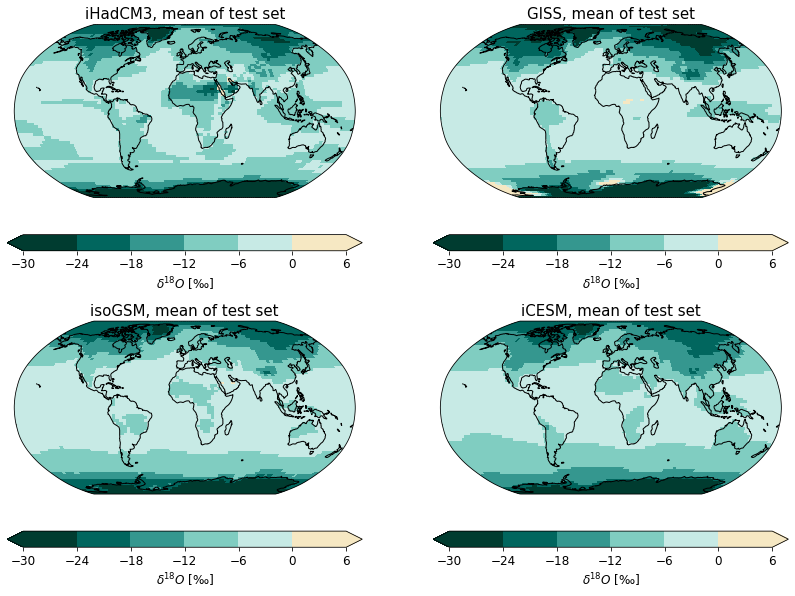

In [9]:
n_rows=2
n_cols=2

fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=np.array([n_cols, n_rows])*mean_style["FIGSIZE"], subplot_kw={'projection': mean_style["PROJECTION"]})
for i, key in enumerate(list(conditions.keys())):
    plot_map(ax[i//2,i%2], np.nanmean(gt_l[i][0],axis=(0,1)), descriptions_l[i][0]["DATASET_DESCRIPTION"], mean_style, 
             title=descriptions_l[i][0]["DATASET_DESCRIPTION"]["CLIMATE_MODEL"]+", mean of test set")

plt.savefig("Images/means.jpg")
plt.show()

### Standard deviations

c:\Users\49159\Anaconda3\envs\GrouPyTorch\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


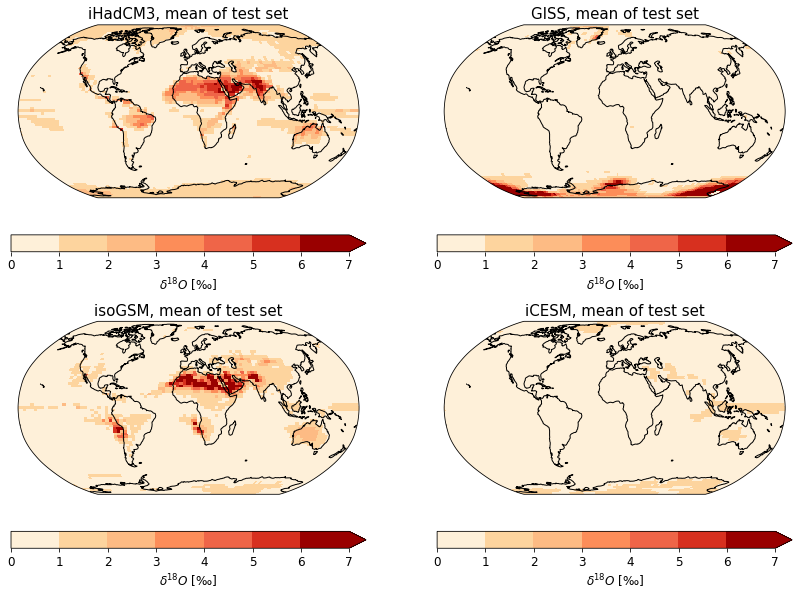

In [10]:
n_rows=2
n_cols=2

fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=np.array([n_cols, n_rows])*std_style["FIGSIZE"], subplot_kw={'projection': std_style["PROJECTION"]})
for i, key in enumerate(list(conditions.keys())):
    plot_map(ax[i//2,i%2], np.nanstd(gt_l[i][0],axis=(0,1)), descriptions_l[i][0]["DATASET_DESCRIPTION"], std_style, 
             title=descriptions_l[i][0]["DATASET_DESCRIPTION"]["CLIMATE_MODEL"]+", std of test set")

plt.savefig("Images/stds.jpg")
plt.show()

### Correlation maps

In [11]:
dsets = []
for d in descriptions_l:
    dsets.append(find_and_load_dataset(output_folder, d[0]["DATASET_DESCRIPTION"]))

In [12]:
data_dicts = []
for ds in dsets:
    t = ds["train"]["predictors"][:,:1,...]  # second index is for specifying the variables
    p = ds["train"]["predictors"][:,1:,...]  # second index is for specifying the variables
    o = ds["train"]["targets"][:]
    
    c_t = get_correlation(t,o)[0,...]
    c_p = get_correlation(p,o)[0,...]

    max_cor = np.amax([abs(c_p),abs(c_t)], axis=0)
    argmax_cor = np.argmax([abs(c_p),abs(c_t)],axis=0)
    
    tas_mask = np.where((argmax_cor == 1),True,False)
    pr_mask = np.where((argmax_cor == 0),True,False)

    tas_img = np.ma.masked_array(max_cor, np.invert(tas_mask))
    pr_img = np.ma.masked_array(max_cor, np.invert(pr_mask))

    data_dict = {"tsurf": tas_img,
                 "prec": pr_img}
    data_dicts.append(data_dict)

c:\Users\49159\Anaconda3\envs\GrouPyTorch\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


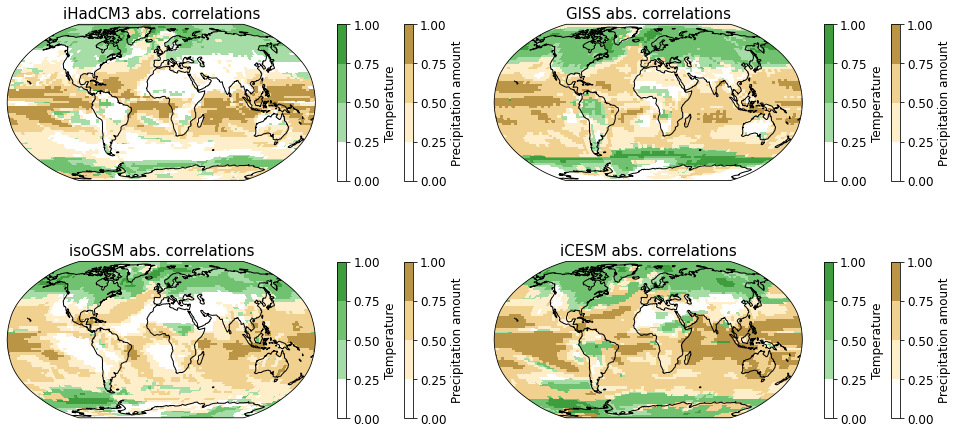

In [17]:
n_rows=2
n_cols=2

fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=np.array([n_cols, n_rows])*corr_style["FIGSIZE"], subplot_kw={'projection': mean_style["PROJECTION"]})
for i, m_key in enumerate(list(conditions.keys())):
    plot_masked_data(ax[i//2,i%2], data_dicts[i], descriptions_l[i][0]["DATASET_DESCRIPTION"], corr_style, 
                     title=m_key +" abs. correlations")
    
    divider = make_axes_locatable(ax[i//2,i%2])
    for j, key in enumerate(list(data_dicts[i].keys())):
        if j==0:
            ax_cb = divider.new_horizontal(size="3%", pad=0.3, axes_class=plt.Axes)
        else:
            ax_cb = divider.new_horizontal(size="3%", pad=0.8, axes_class=plt.Axes)            
        fig.add_axes(ax_cb)
        cbar = fig.colorbar(
            matplotlib.cm.ScalarMappable(cmap=corr_style["CMAPS"][key], norm=corr_style["NORM"]),
            spacing='proportional',
            orientation='vertical',
            extend=corr_style["CBAR_EXTEND"], cax=ax_cb)
        cbar.set_label(corr_style["CBAR_LABELS"][key], fontsize=corr_style["CBAR_FONTSIZE"])
        cbar.ax.tick_params(labelsize=corr_style["CBAR_FONTSIZE"])
plt.savefig("Images/corrs.jpg")
plt.show()